In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import nest
import itertools
from utils.inputs import generate_piecewise_constant_signal
from utils.capacity import compute_capacity
import seaborn as sns
import numpy as np
from scipy import sparse
from sklearn.decomposition import PCA


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Oct 17 2024 16:05:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def get_sparse_matrix(rows,cols,probability,seed):
    # Set the random seed for reproducibility
    rng = np.random.default_rng(seed)
    # Generate a random sparse matrix with values 0 or 1
    sparse_matrix = sparse.random(rows, cols, density=probability, format='csr', random_state=rng, data_rvs=lambda s: rng.integers(1, 2, size=s))
    # Convert the sparse matrix to a dense format
    dense_matrix = sparse_matrix.toarray()
    return dense_matrix


In [3]:
class BrunelNetwork:
    def __init__(self, g, eta,w, w_e,w_i, neuron_params, NE, NI,CE,CI,NrE, NrI, rec_start, rec_stop):
        self.num_ex = NE  # number of excitatory neurons
        self.num_in = NI  # number of inhibitory neurons
        self.c_ex = CE  # number of excitatory connections
        self.c_in = CI  # number of inhibitory connections
        self.w_e = w_e  # excitatory weight
        self.w_i = w_i  # inhibitory weight
        self.w = w
        self.n_rec_ex = NrE # number of recorded excitatory neurons, both excitatory and inhibitory
        self.n_rec_in = NrI # number of recorded in neurons, both excitatory and inhibitory
        self.rec_start = rec_start
        self.rec_stop = rec_stop
        self.neuron_params = neuron_params  # neuron params
        self.ext_rate = (self.neuron_params['V_th'] 
                         / (0.1 * self.c_ex * self.neuron_params['tau_m'])
                         * eta * 1000. * self.c_ex)
 
    def create(self):
        # Create the network
        
        # First create the neurons
        self.neurons_ex = nest.Create('iaf_psc_delta', self.num_ex, params=self.neuron_params)
        self.neurons_in = nest.Create('iaf_psc_delta', self.num_in, params=self.neuron_params)
        
        self.neurons = self.neurons_ex + self.neurons_in
        
        # Then create the external spike generator
        self.poisson_noise = nest.Create('poisson_generator', params={'rate': self.ext_rate, 'stop': self.rec_stop})

        #Then create spike detectors
        self.recorder_ex = nest.Create('spike_recorder',
                                       self.n_rec_ex,
                                       params={'start' : self.rec_start, 'stop': self.rec_stop})
        self.recorder_in = nest.Create('spike_recorder',
                                       self.n_rec_in,
                                       params={'start': self.rec_start, 'stop': self.rec_stop})

        # Next we connect the neurons
        # Iterate by row in w
        # for i_row in range(self.num_ex):
        #     # select non-zero weights
        #     nonzero = self.w_e != 0
        #     nonzero_row = nonzero[i_row]
        #     nest.Connect(self.neurons_ex[i_row], self.neurons_ex[nonzero_row],
        #                 conn_spec = {'rule': 'all_to_all'},
        #                 syn_spec = {'synapse_model': 'static_synapse',
        #                             'delay': 1.5,
        #                             'weight': self.w_e[i_row][nonzero_row].reshape((-1,1))})
        nest.Connect(self.neurons_ex, self.neurons_ex,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_ex},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w})        
        nest.Connect(self.neurons_ex, self.neurons_in,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_ex},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w})
        nest.Connect(self.neurons_in, self.neurons,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_in},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w_i})
        # test
        # self.poisson_noise = nest.Create('inhomogeneous_poisson_generator', 1)
        # step_duration = 1000#50.    # [ms]
        # scale = self.ext_rate / 2.    # scale input amplitude (max. rate)
        # print(scale)
        # sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=1, num_steps=1, step_duration=self.rec_stop, resolution=1., scale=scale)#int(self.rec_stop/step_duration)
        # self.sig=sig
        # self.times=times
        # nest.SetStatus(self.poisson_noise, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})
        
        # Then we connect the external drive to the neurons
        nest.Connect(self.poisson_noise, self.neurons,
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': 0.1})
                                #  'weight': 0.1
                                 
        
        # Then we connect the the neurons to the spike recorders
        nest.Connect(self.neurons_ex[:self.n_rec_ex], self.recorder_ex, 'one_to_one')
        nest.Connect(self.neurons_in[:self.n_rec_in], self.recorder_in, 'one_to_one')
        
        # Add voltimeter for the decoder
        self.vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': 1})
        nest.Connect(self.vm, self.neurons_ex)

    def simulate(self, t_sim):
        # Simulate the network with specified 
        nest.Simulate(t_sim)
        # to acquire the last time step in the multimeter
        nest.Simulate(1)
        
    def get_data(self):
        # get spikes from recorders
        spikes_ex = []
        spikes_in = []
        
        for i in range(self.n_rec_ex):
            spikes_ex.append(
                list(np.sort(nest.GetStatus(self.recorder_ex)[i]['events']['times'])))
        for i in range(self.n_rec_in):
            spikes_in.append(
                list(np.sort(nest.GetStatus(self.recorder_in)[i]['events']['times'])))
            
        return spikes_ex, spikes_in


In [4]:
# Helper function to plot spiking activity
def plot_raster_rate(spikes_ex, spikes_in, rec_start, rec_stop, figsize=(9, 5),save=False):
    
    spikes_ex_total = list(itertools.chain(*spikes_ex))
    spikes_in_total = list(itertools.chain(*spikes_in))
    spikes_total = spikes_ex_total + spikes_in_total
    
    n_rec_ex = len(spikes_ex)
    n_rec_in = len(spikes_in)
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(5, 1)
    
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4,0])
    
    ax1.set_xlim([rec_start, rec_stop])
    ax2.set_xlim([rec_start, rec_stop])
    
    ax1.set_ylabel('Neuron ID')
    
    ax2.set_ylabel('Firing rate')
    ax2.set_xlabel('Time [ms]')
    
    
    for i in range(n_rec_in):
        ax1.plot(spikes_in[i],
                 i*np.ones(len(spikes_in[i])),
                 linestyle='',
                 marker='o',
                 color='r',
                 markersize=2)
    for i in range(n_rec_ex):
        ax1.plot(spikes_ex[i],
                 (i + n_rec_in)*np.ones(len(spikes_ex[i])),
                 linestyle='',
                 marker='o',
                 color='b',
                 markersize=2)

        
    ax2 = ax2.hist(spikes_ex_total,
                   range=(rec_start,rec_stop),
                   bins=int(rec_stop - rec_start))
    if save:
        plt.savefig('raster.png')

    time_diff = (rec_stop - rec_start)/1000.
    average_firing_rate = (len(spikes_total)
                           / time_diff
                           /(n_rec_ex + n_rec_in))
    print(f'Average firing rate: {average_firing_rate} Bq')

In [5]:
seed = 2
np.random.seed(seed)

In [6]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)  
Ntotal=NE+NI
# synapse parameters
# w = 0.1                    # excitatory synaptic weight (mV)
# w *= np.sqrt(10)
g = 6.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)
# Define J matrix
w = 0.1
#w *= np.sqrt(10)
n_clusters = 1
#wc = [w *i for i in range(1,(n_clusters+1)*2,2)]
w_factor=1# scaling clusters w
wc = [w*w_factor]*n_clusters
w_ex = np.full((NE,NE),w,dtype=np.float64)
nn_c = int(NE/n_clusters)# number of units per cluster
for i_n in range(n_clusters):
    st=i_n*nn_c
    end=(i_n+1)*nn_c
    w_ex[st:end,st:end] = wc[i_n]
wi = np.full((NI,NE),-w*g)
w_i = -w*g
w_sparse = get_sparse_matrix(rows=w_ex.shape[0],cols=w_ex.shape[1],probability=0.1,seed=seed)
w_sparse = w_ex*w_sparse
#w=np.concatenate((w_sparse,wi),axis=0)
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}
params = {'g':g, 
          'eta':1.0,#set external rate above threshold, 
          'w':w,
          'w_e':w_sparse,
          'w_i':w_i,
          'neuron_params':neuron_params,    
          'NE':NE,
          'NI':NI,
          'CE':CE,
          'CI':CI, 
          'NrE':NE, 
          'NrI':NI, 
          'rec_start':0, 
          'rec_stop':1050,
}

<Axes: >

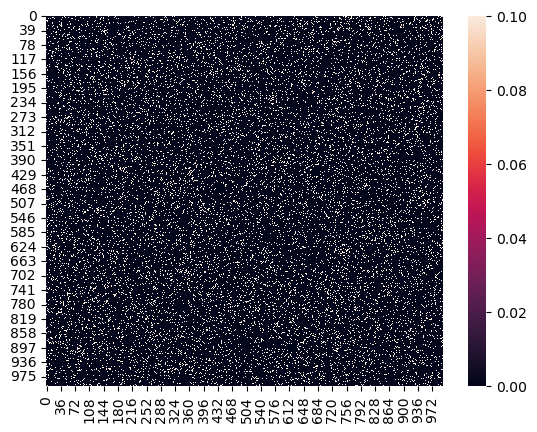

In [7]:
sns.heatmap(w_sparse)

In [8]:
dt = 0.1  # simulation resolution
sim_time = 1100. # simulation time [ms] (for each epoch)
num_threads = 4
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})
network = BrunelNetwork(**params)


Oct 21 17:20:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [9]:
network.create()
network.simulate(sim_time)


Oct 21 17:20:55 NodeManager::prepare_nodes [Info]: 
    Preparing 6258 nodes for simulation.

Oct 21 17:20:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6258
    Simulation time (ms): 1100
    Number of OpenMP threads: 4
    Not using MPI

[ 100% ] Model time: 1100.0 ms, Real-time factor: 0.3339

Oct 21 17:20:56 SimulationManager::run [Info]: 
    Simulation finished.

Oct 21 17:20:56 NodeManager::prepare_nodes [Info]: 
    Preparing 6258 nodes for simulation.

Oct 21 17:20:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6258
    Simulation time (ms): 1
    Number of OpenMP threads: 4
    Not using MPI

[ 100% ] Model time: 1101.0 ms, Real-time factor: 0.1340

Oct 21 17:20:56 SimulationManager::run [Info]: 
    Simulation finished.


Average firing rate: 11.497904761904762 Bq


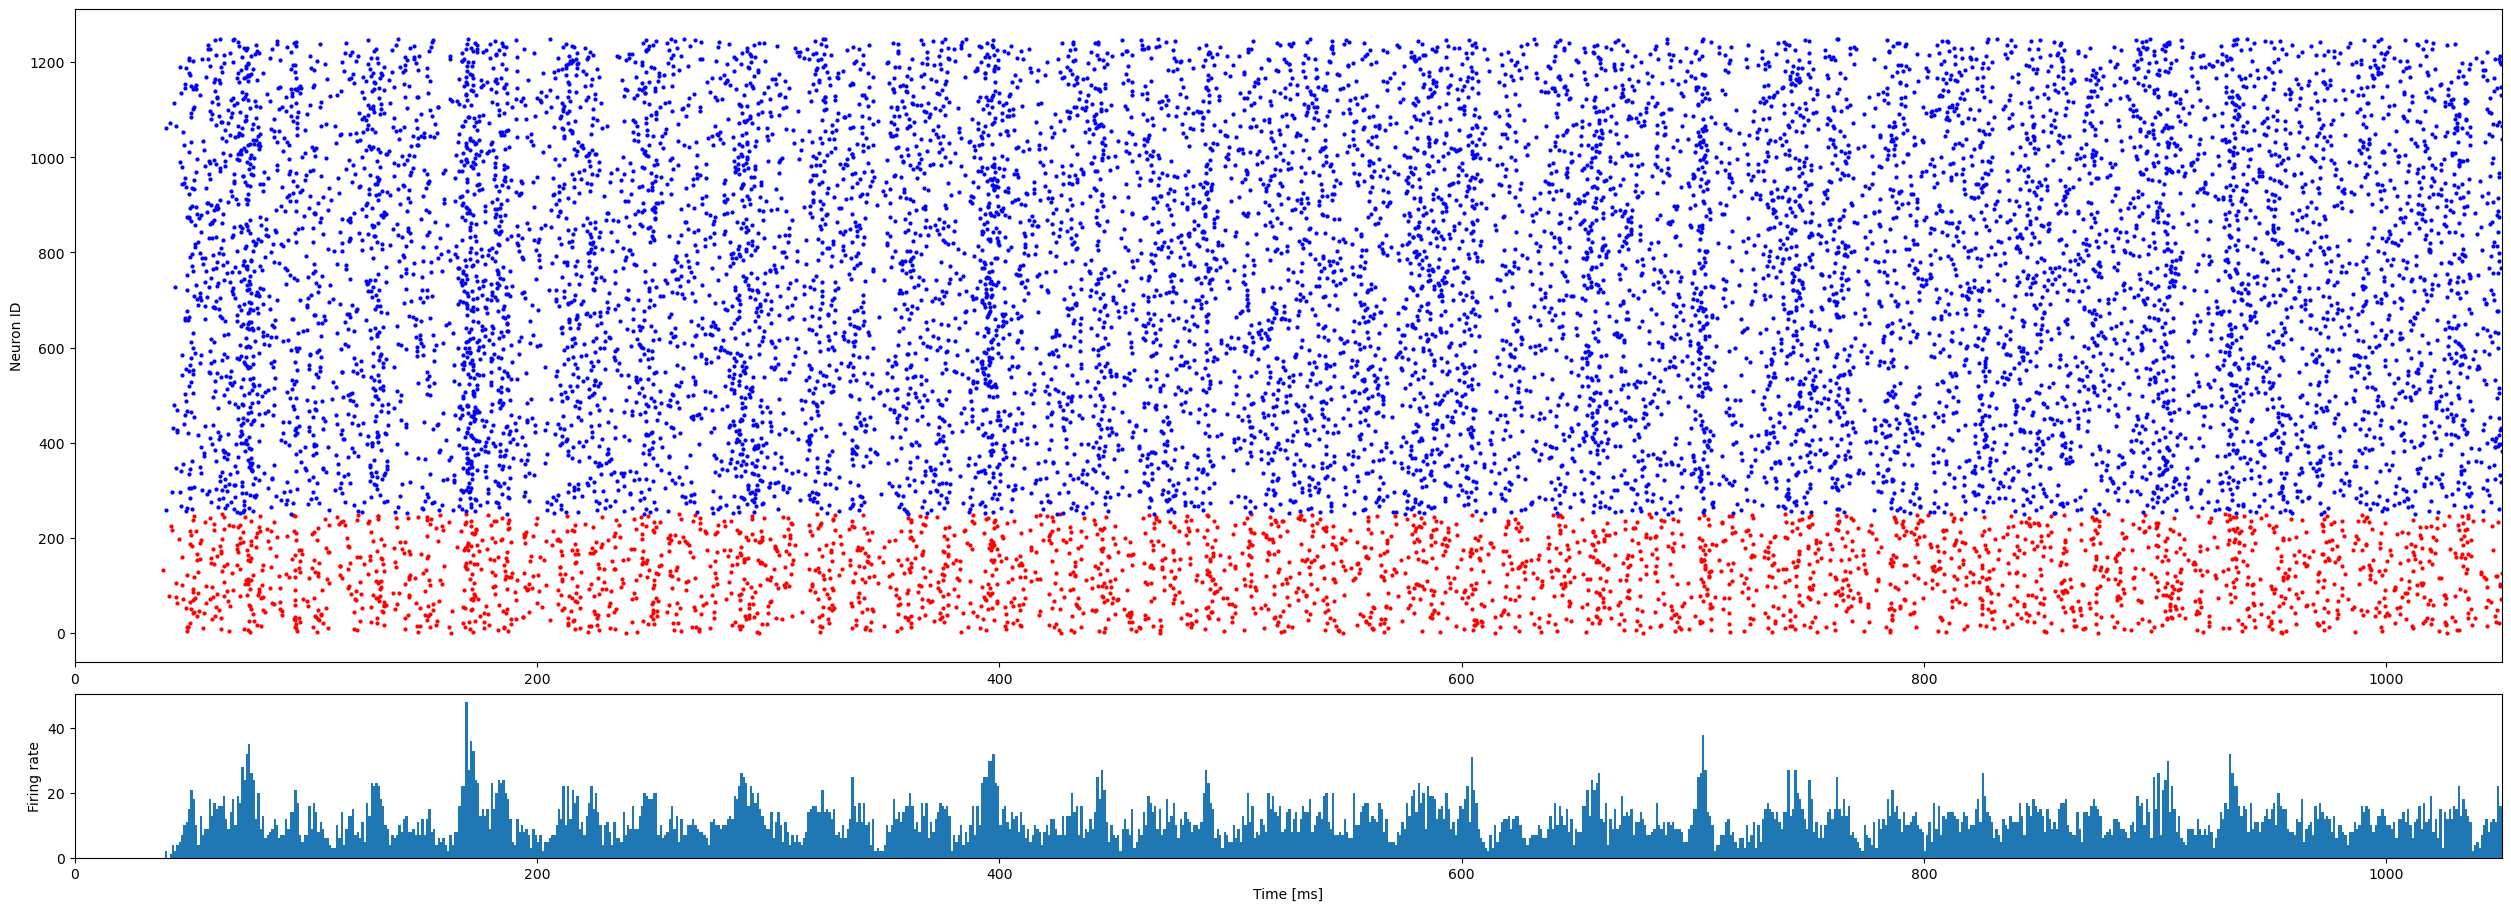

In [10]:
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'],figsize=(25,9))

In [11]:
network.poisson_noise

NodeCollection(metadata=None, model=poisson_generator, size=1, first=1251)

In [40]:
connections = nest.GetConnections(source=network.neurons_ex, target=network.neurons_ex)
C = np.zeros((len(network.neurons_ex) + 1, len(network.neurons_ex) + 1))
for c in connections:
    C[c.source][c.target] = c.weight


[0.         0.31622777]


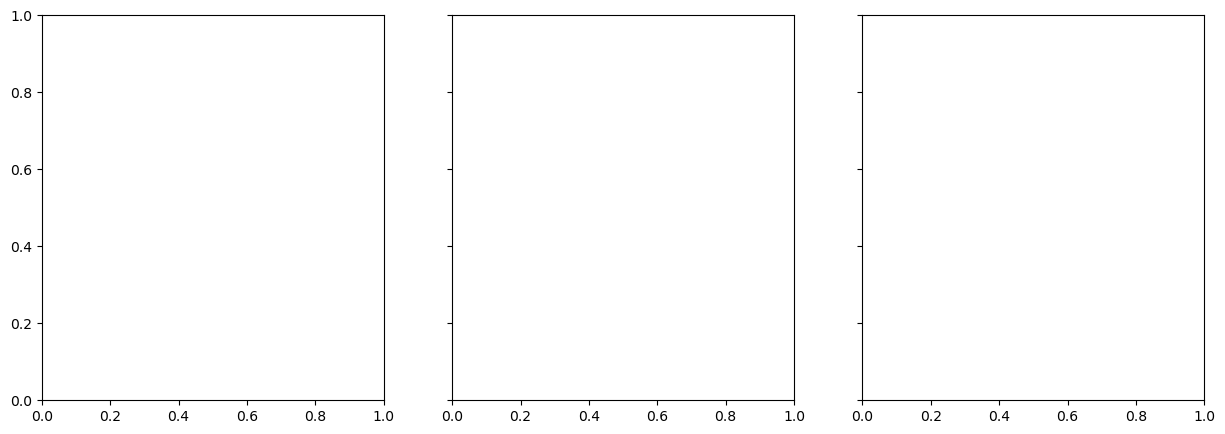

In [41]:
f,ax=plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
#sns.heatmap(C[1:,1:],ax=ax[0])
#sns.heatmap(w_sparse,ax=ax[1])
diff = C[1:,1:]-w_sparse
#sns.heatmap(diff,ax=ax[2])
print(np.unique(C))

In [42]:
def single_isi(spike_train, min_val, max_val, num_bins):
    
    spike_train = np.array(spike_train)
    isis = spike_train[1:] - spike_train[:-1]
    hist, bins = np.histogram(isis,
             range=(min_val, max_val),
             bins=num_bins,
             density=True)
    
    centered_bins = (bins[1:] + bins[:-1])/2 
    
    print(f'Mean of ISI: {isis.mean()}' )
    print(f'Standard deviation of ISI: {isis.std()}' )
    print(f'Coefficient of variation: {isis.std()/isis.mean()}')
    
    plt.figure(figsize=(4,4))
    plt.plot(bins[1:], hist)
    
    
def average_isi(spike_trains, min_val, max_val, num_bins):
    
    means = []
    stds = []
    hists = []
    
    for i, spike_train in enumerate(spike_trains):
        
        if len(spike_train) < 1:
            continue
        
        spike_train = np.array(spike_train)
        isis = spike_train[1:] - spike_train[:-1]

        hist, bins = np.histogram(isis,
                                  range=(min_val, max_val),
                                  bins=num_bins,
                                  density=True)

        hists.append(hist)    
        means.append(isis.mean())
        stds.append(isis.std())
    
    hist = np.array(hists)
    average_hist = hist.mean(axis=0)
    means = np.array(means)
    stds = np.array(stds)
    
    print(f'Average mean of ISI: {means.mean()}')
    print(f'Average std of ISI: {stds.mean()}')
    print(f'Average CV of ISI: {stds.mean()/means.mean()}')
        
    
    centered_bins = (bins[1:] + bins[:-1])/2
    
    plt.figure(figsize=(4,4))
    plt.plot(bins[1:], average_hist)

/home/closada/miniconda3/envs/eitn_proj/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:invalid value encountered in divide


Average mean of ISI: 88.31904376318943
Average std of ISI: 49.01664158859817
Average CV of ISI: 0.5549951573301325
Average mean of ISI: 86.55480983682983
Average std of ISI: 47.58595590958097
Average CV of ISI: 0.5497782965416755


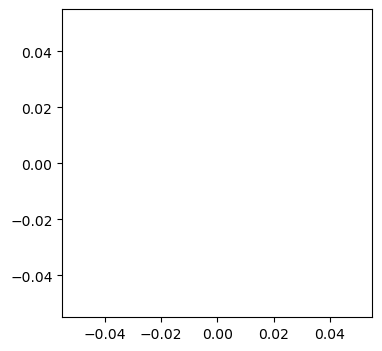

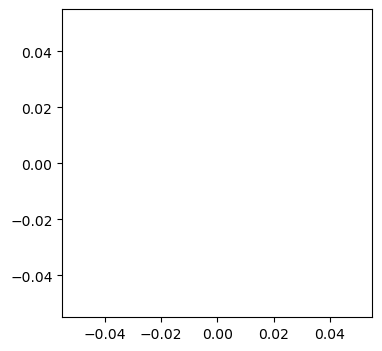

In [43]:
average_isi(spikes_ex, min_val=0., max_val=50, num_bins=100)
average_isi(spikes_in, min_val=0., max_val=50, num_bins=100)

### for signal

AttributeError: 'BrunelNetwork' object has no attribute 'times'

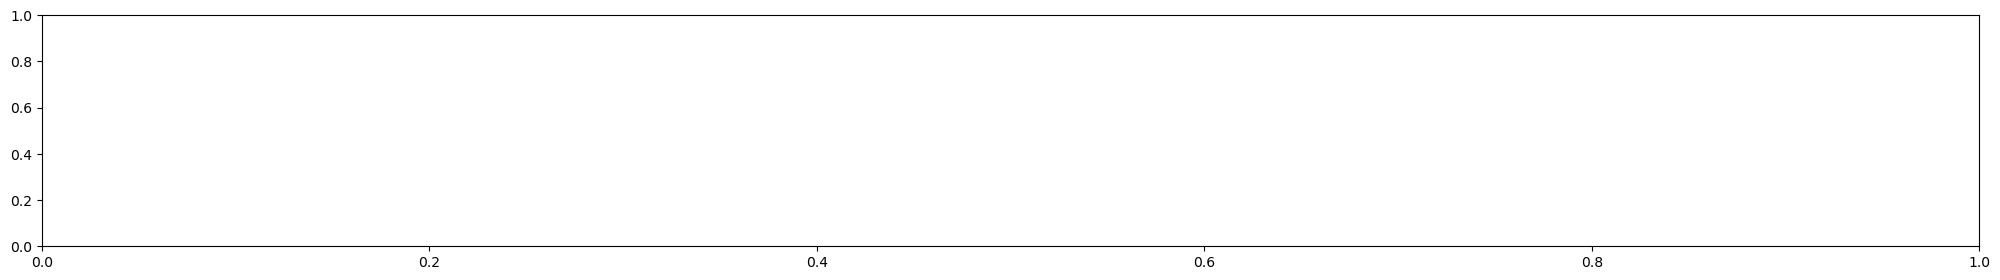

In [44]:
fig, ax = plt.subplots(figsize=(25,3))
ax.plot(network.times, network.sig)
#ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [22]:
activity = network.vm.events
indices = np.sort(np.unique(activity['senders']))
states = np.zeros((NE, int(sim_time)))
for idx, i in enumerate(indices):
    states[idx, :] = activity['V_m'][np.where(activity['senders']==i)[0]]

In [23]:
states.shape

(1000, 5000)

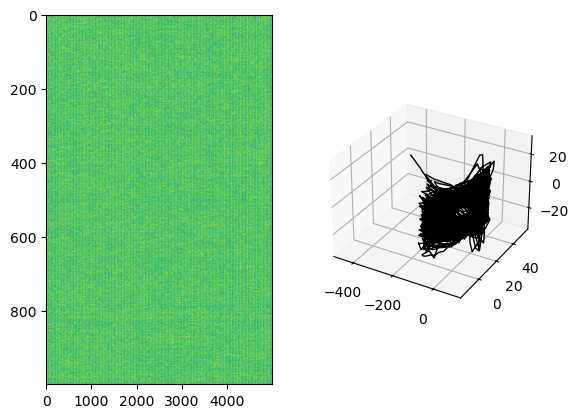

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=states.shape[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

In [15]:
network.sig.shape

(15001,)

In [25]:
# exclude initial values at time 0.
sig = network.sig[1:]
times = network.times[1:]
# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))

ValueError: Found input variables with inconsistent numbers of samples: [5000, 15000]